In [1]:
'''The plan is to simulate stellar mass following the well-known IMF to obtain a random star
out of 10.000 generated or take them all and test them first with a planet (5yr period, 10 Mj mass). 
The next step is to select randomly a pair (M, P) and compute the eclipsing time and probabilities
many times to obtain the final dependence of number of transits with stellar mass.'''

#Standard python packages

import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as c
from math import factorial as fac
import IMF_Generator

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')
%matplotlib inline

In [2]:
'''Stellar Mass Distribution
Assuming stellar mass follows a Salpeter 1955 IMF with slope = -2.35
Stellar mass from 0.1 to 10 solar masses'''

slopes   = [2.35]  #Inside the script is already negative
masslims = [0.1, 10]
myimf = IMF_Generator.MultiPartPowerLaw(np.array(slopes), np.array(masslims))
m     = np.linspace(masslims[0],masslims[-1],200)
lnpdf = myimf.pdf(m)
cdf   = myimf.cdf(m)
N     = 10000
ranmass = myimf.rvs(N)

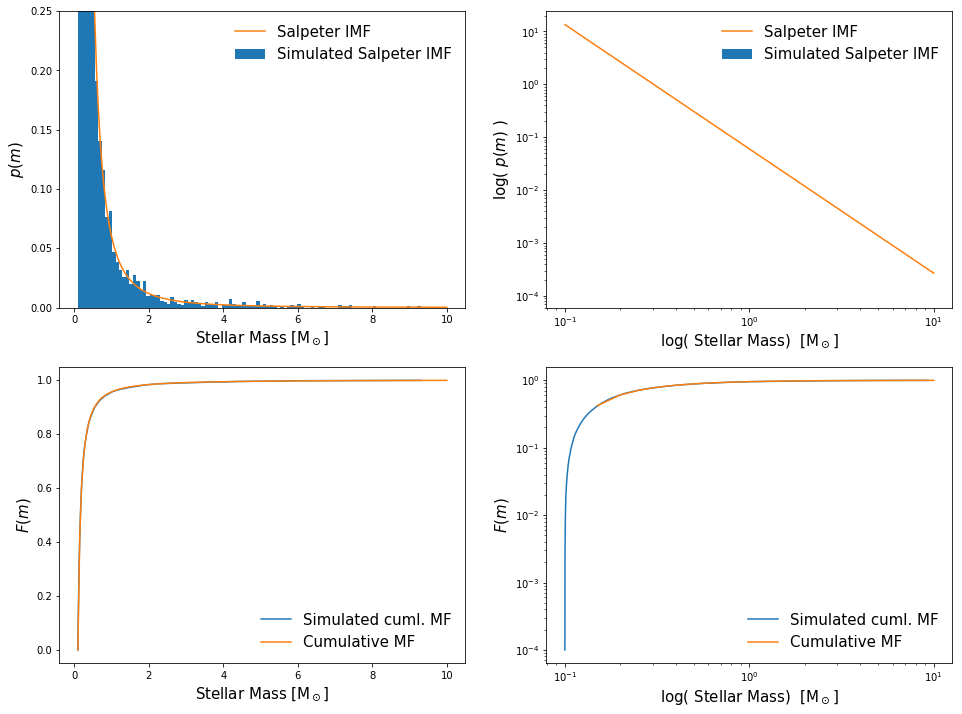

In [3]:
fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize = (16,12), nrows = 2, ncols = 2)

axA.hist(ranmass, bins = 100, normed = True, label = 'Simulated Salpeter IMF')
axA.plot(m, np.exp(lnpdf), label = 'Salpeter IMF')
axA.set_xlabel(r'Stellar Mass [M$_\odot$]', size = 15)
axA.set_ylabel('$p(m)$', size = 15)
axA.set_ylim(0, 0.25)
axA.legend(frameon = False, prop = {'size': 15})

axB.hist(ranmass, bins = 10, normed = True, label = 'Simulated Salpeter IMF')
axB.plot(m, np.exp(lnpdf), label = 'Salpeter IMF')
axB.set_xlabel(r'log( Stellar Mass)  [M$_\odot$]', size = 15)
axB.set_ylabel('log( $p(m)$ )', size = 15)
axB.set_yscale('log')
axB.set_xscale('log')
axB.legend(frameon = False, prop = {'size': 15})

c = np.linspace(1.0/N, 1, N)
axC.plot(np.sort(ranmass), c, label = 'Simulated cuml. MF')
axC.plot(m, cdf, label = 'Cumulative MF')
axC.set_xlabel(r'Stellar Mass [M$_\odot$]', size = 15)
axC.set_ylabel('$F(m)$', size = 15)
axC.legend(frameon = False, prop = {'size': 15})

axD.plot(np.sort(ranmass), c, label = 'Simulated cuml. MF')
axD.plot(m, cdf, label = 'Cumulative MF')
axD.set_xlabel(r'log( Stellar Mass)  [M$_\odot$]', size = 15)
axD.set_ylabel('$F(m)$', size = 15)
axD.set_yscale('log')
axD.set_xscale('log')
axD.legend(frameon = False, prop = {'size': 15});

plt.savefig("Period_distribution_Cumming.png")

In [4]:
'''Functions and definitions used along the distributions'''

G         = 2.959e-4           # AU^3 / Msun day^2
Masses_CF = 9.5458e-4          #From jupiter mass to solar mass

def MajorAxis(M, m, P):
    
    #M and m in solar mass, P in days = Major axis in AU
    return (G * (M + m) / (4.0*np.pi**2))**(1.0/3.0) * P**(2.0/3.0)

def Eclipsing_Time(M, m, P, epsilon):
    return P * (epsilon / np.pi) * (m / (2.0*M))**(1.0/3.0)

def ocurrence(a, m, M, R, e, epsilon):
    #a in AU, m and M in solar mass, R in AU
    
    RH = epsilon * ( a*(1 - e)*(m / (3.0*M) )**(1.0/3.0) )
    #return R/a              #Point-planet
    return (RH + R) / a      #Hill sphere radius

def Real_prob(Gaia_lifetime, Eclising_duration, Trials):
    return 1.0 - ( (Gaia_lifetime - Eclising_duration) / Gaia_lifetime )**Trials

def Prob_total(p1, p2, p3, p4):
    return np.array(p1*p2*p3*p4)

In [5]:
Star_mass     = np.sort(ranmass)
Planet_mass   = 10.0*Masses_CF #In solar mass
Planet_period = 1825.0         #Days

Planet_maxis  = np.array(MajorAxis(Star_mass, Planet_mass, Planet_period))
R_sun         = 0.00465                              #In AU
R_star        = np.array(R_sun * (Star_mass)**0.8)   #Following a Main Sequence Mass-to-Radius relation

Prob   = ocurrence(Planet_maxis, Planet_mass, Star_mass, R_star, e = 0.0, epsilon = 0.3)
E_time = Eclipsing_Time(Star_mass, Planet_mass, Planet_period, epsilon = 0.3)

P1     = 0.17                                   #Cassen et al. 2012 for (0.3-10M_J) within (0.5-10AU)
P2     = 1.00                                   #Best case
P3     = Prob                                   #Planet_mass = 10M_J, Planet_period = 5yr, epsilon = 0.3
P4     = Real_prob(Planet_period, E_time, 70.0) #Gaia NO-observation probability

#print(np.sort(Star_mass))

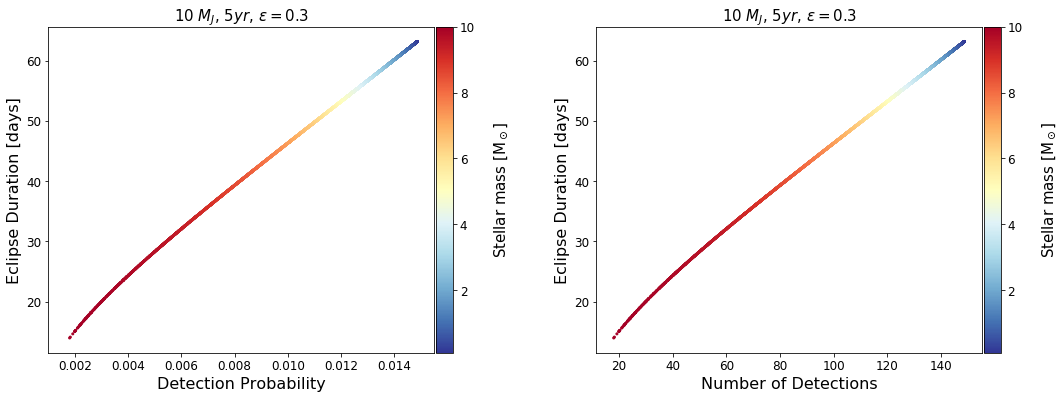

In [6]:
plt.rc('xtick', labelsize = 12) 
plt.rc('ytick', labelsize = 12) 

Color = np.linspace(0.1, 10.0, N)     #Creates 16 different colors
#cm    = plt.cm.get_cmap('rainbow')    #This is the color map used
cm    = plt.cm.get_cmap('RdYlBu_r')

fig, ((axA, axB)) = plt.subplots(figsize = (18,6), nrows = 1, ncols = 2)

A = axA.scatter(Prob_total(P1, P2, P3, P4), E_time, c  = Color, cmap = cm, s = 4)
axA.set_xlabel('Detection Probability', size = 16)
axA.set_ylabel('Eclipse Duration [days]', size = 16)
axA.set_xlim(0.0010, 0.0155)
axA.set_title(r'$10$ $M_J$, $5yr$, $\epsilon = 0.3$', size = 15)
cbar_A = plt.colorbar(A, ax = axA, pad = 0.005)
cbar_A.set_label(r'Stellar mass [M$_\odot$]', rotation = 90, size = 15, labelpad = 17)

B = axB.scatter(Prob_total(P1, P2, P3, P4)*N, E_time, c  = Color, cmap = cm, s = 4)
axB.set_xlabel('Number of Detections', size = 16)
axB.set_ylabel('Eclipse Duration [days]', size = 16)
axB.set_title(r'$10$ $M_J$, $5yr$, $\epsilon = 0.3$', size = 15)
cbar_B = plt.colorbar(B, ax = axB, pad = 0.005)
cbar_B.set_label(r'Stellar mass [M$_\odot$]', rotation = 90, size = 15, labelpad = 17)

#cm    = plt.cm.get_cmap('RdYlBu_r')
plt.savefig('Detection_Prob_Number_Correct.png')

In [7]:
# fig, ((axA, axB)) = plt.subplots(figsize = (18,6), nrows = 1, ncols = 2)

# A = axA.scatter(Prob_total(P1, P2, P3, P4)*10000, E_time, c  = Color, cmap = cm, s = 4)
# axA.set_xlabel('Number of Detections', size = 16)
# axA.set_ylabel('Eclipse Duration [days]', size = 16)
# axA.set_title(r'$10$ $M_J$, $10yr$, $\epsilon = 0.3$', size = 15)
# #axA.set_xlim(100,140)
# cbar_A = plt.colorbar(A, ax = axA, pad = 0.005)
# cbar_A.set_label(r'Stellar mass [M$_\odot$]', rotation = 90, size = 15, labelpad = 17)

# BINS = 20
# N = Prob_total(P1, P2, P3, P4)*10000
# n, bins, patches = axB.hist(N, BINS)   

# Color = np.linspace(0.1, 10.0, BINS)
# #cm    = plt.cm.get_cmap('rainbow')

# for c, p in zip(Color[::-1], patches):
#     plt.setp(p, 'facecolor', cm(np.log10(c)))
#     #plt.setp(p, 'facecolor', cm(c)) 
    
# axB.set_xlabel('Number of Detections', size = 15)
# axB.set_ylabel('Frequency', size = 15)    

# '''The colors for the histogram are not totally matching the ones
# in the number of dectections plot.'''

# plt.savefig('Detections.png')

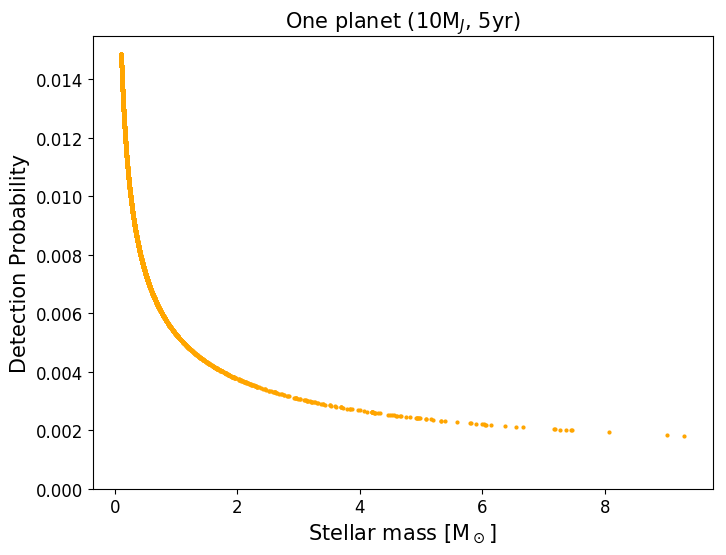

In [8]:
plt.figure(figsize = (8,6), dpi = 100)
plt.scatter(Star_mass, Prob_total(P1, P2, P3, P4), s = 4, c= 'orange')
plt.xlabel(r'Stellar mass [M$_\odot$]', size = 15)
plt.ylabel('Detection Probability', size = 15)
plt.title( r'One planet (10M$_J$, 5yr)', size = 15)
plt.ylim(0, 0.0155)

plt.savefig('StellarMass_Detections_0.png')

9002
562
168
91
55
21
21
16
9
16
11
7
4
6
2
3
3
1
0
1
1
0
[  0.1    0.55   1.     1.45   1.9    2.35   2.8    3.25   3.7    4.15
   4.6    5.05   5.5    5.95   6.4    6.85   7.3    7.75   8.2    8.65
   9.1    9.55  10.  ]


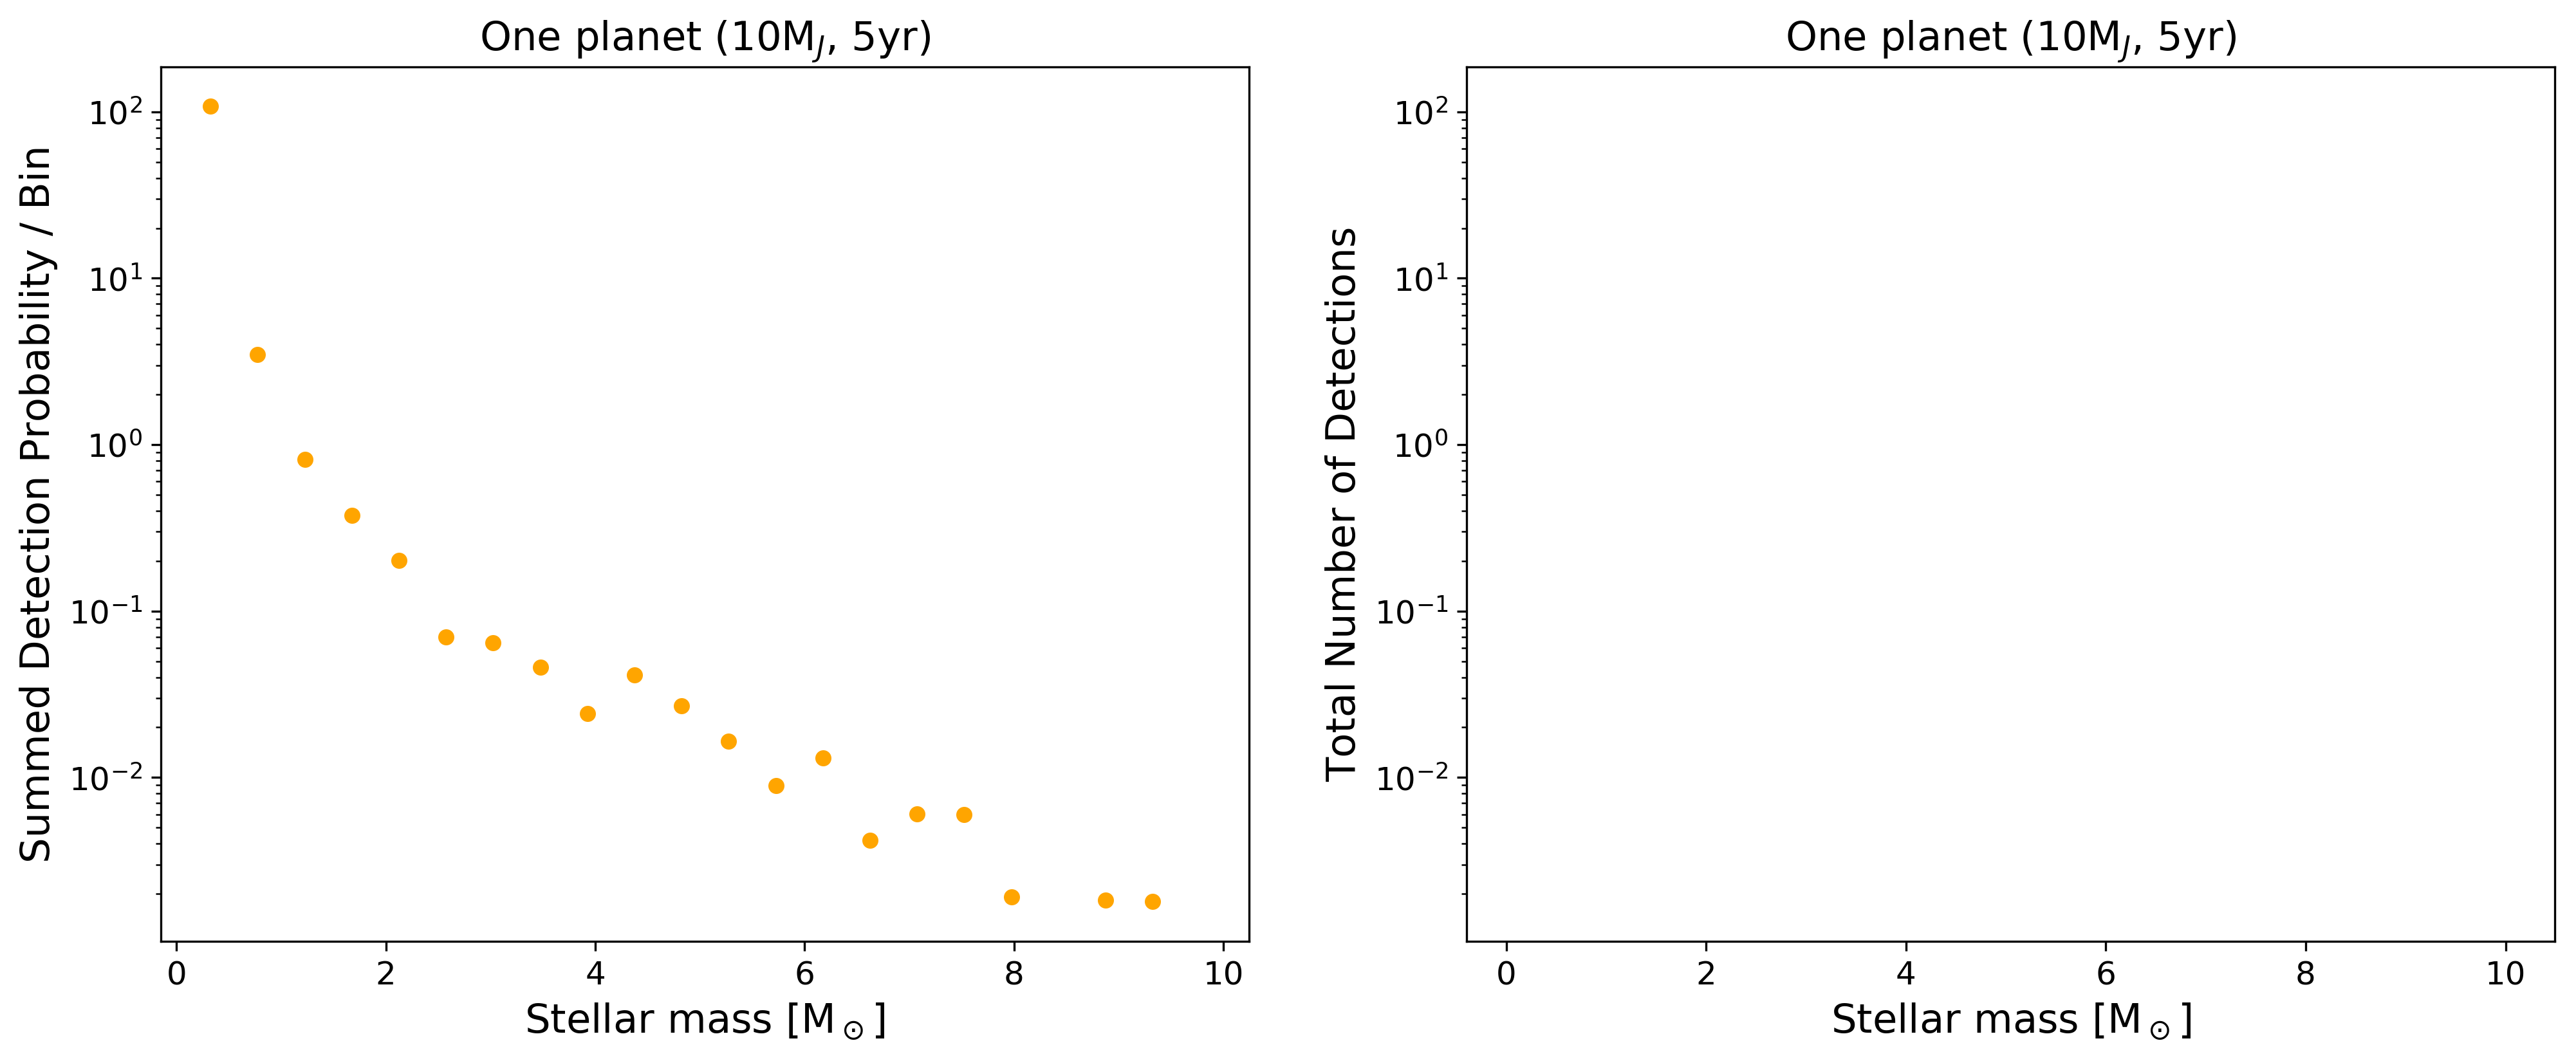

In [9]:
Number = np.linspace(0.1, 10, 23)

#print(N)
AAA = np.array([Star_mass, Prob_total(P1, P2, P3, P4)])
#print(AAA[0:,][0])
A = []
NN = []
NNN = []
for i in range(len(Number) -1):
    
    B = []
    NN.append( (Number[i] + Number[i+1])/2.0 )
    NNN.append((Number[i] + Number[i+1])/2.0 - Number[i+1])
    for j in range(len(Star_mass)):
        
        if ((AAA[0:,j][0] > Number[i]) and (AAA[0:,j][0] < Number[i+1])):
            B.append(AAA[0:,j][1])
    print(len(B))      
    A.append(np.sum(B)) 
    
print(Number)    
fig, ((axA, axB)) = plt.subplots(figsize = (16,6), nrows = 1, ncols = 2, dpi = 300)

axA.plot(NN, A, '.', ms = 10, color = 'orange')
axA.set_yscale('log')
axA.set_xlabel(r'Stellar mass [M$_\odot$]', size = 15)
axA.set_ylabel('Summed Detection Probability / Bin', size = 15)
axA.set_title( r'One planet (10M$_J$, 5yr)', size = 15)

axB.bar(NN, A, width = 0.45, color = 'orange') #0.45 ( (N[i] + N[i+1])/2 - N[i+1] )*2
axB.set_yscale('log')
axB.set_xlabel(r'Stellar mass [M$_\odot$]', size = 15)
axB.set_ylabel('Total Number of Detections', size = 15)
axB.set_title( r'One planet (10M$_J$, 5yr)', size = 15)

plt.savefig('StellarMass_Detections_1.png')